In [1]:
import sys,os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import cmocean.cm as cmo
from scipy.interpolate import RegularGridInterpolator


import netCDF4 as nc
import requests
import math
import io
import re
from pandas.plotting import register_matplotlib_converters

import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def deg_to_card(d):
    dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ix = round(d / (360. / len(dirs)))
    return dirs[ix % len(dirs)]

/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Load Joao's model data

model = xr.open_dataset('/source/Data/Bathymetry/nz5km_grd.nc')
model_h = model['h']
model_lon = model['lon_rho']
model_lat = model['lat_rho']


In [3]:
# Stations set 1
lats = np.array([-36.5,-36.5,-36.5,-36.5,-36.5,-37,-37,-37,-37,-37,-37.5,-37.5,-37.5,-37.25,-37.25,-37.25,-37.25,-37.75,-37.75])
lons = np.array([176.5,177,177.5,178,178.5,176.5,177,177.5,178,178.5,176.5,177,177.5,176.5,177,177.5,178,177,177.5])

opotiki_lat = -38.0123 
opotiki_lon = 177.2871

/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/Cartopy-0.17.1.dev174_-py3.6-linux-x86_64.egg/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


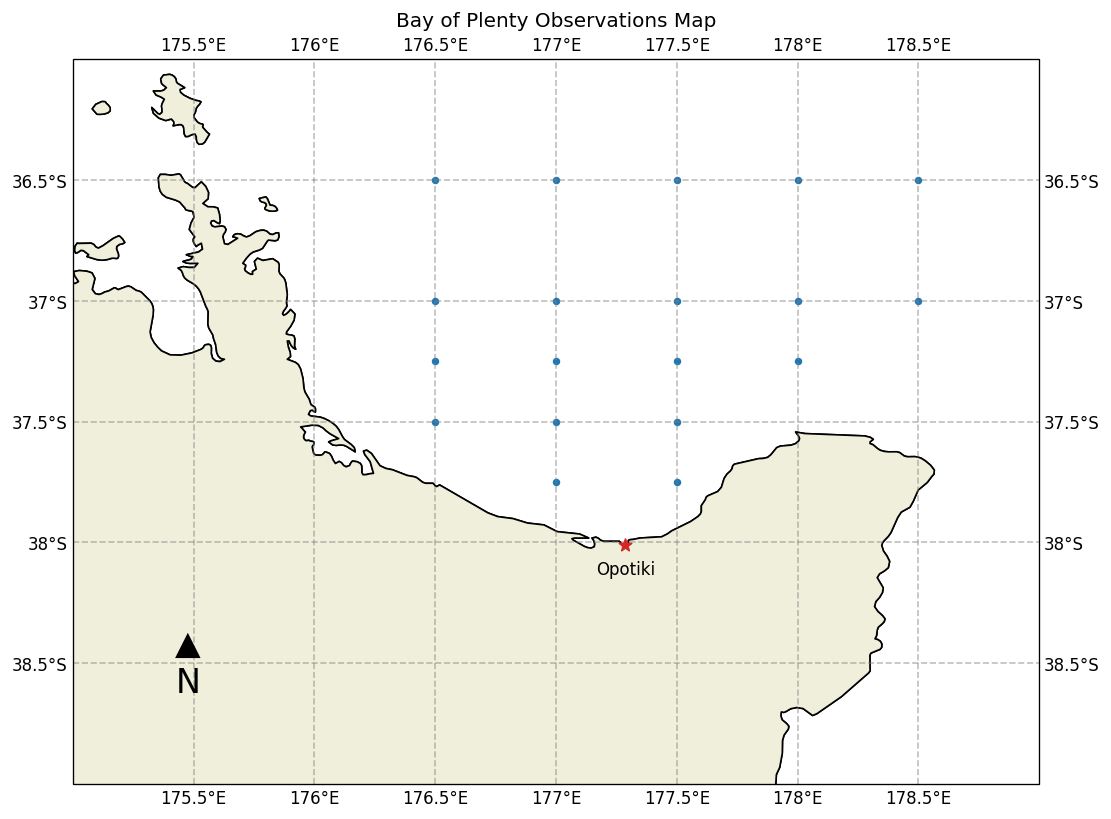

In [37]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [175, 179, -39, -36]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

# plot bathymetry

levels = [100,500,1000,2000,3000,4000,5000,6000,7000]
#cmap = cmo.tools.lighten(cmo.deep, 0.25)
cmap = cmo.deep

ms = 12
marker = 'o'
dot_mpi = ax.scatter(lons+lon_offset,lats,s=ms,c='tab:blue',marker=marker)


# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Bay of Plenty Observations Map')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
#gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,0.5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(opotiki_lon+lon_offset,opotiki_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(opotiki_lon, opotiki_lat-0.1, 'Opotiki', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=101)
ax.set_ylabel('Latitude')
left = 175.5
bottom = -38.5
ax.quiver(left+lon_offset,bottom, 0, 1)
ax.set_ylabel('Latitude')

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)

plt.show()

In [5]:
model = xr.open_dataset('/ocean/Moana/NZB/moana_backboneV2/MEAN_NZ.nc')

In [33]:
lev = 49
res = 35

v = model['v'][0,lev,:,:]
u = model['u'][0,lev,:,:]
lon_u = model['lon_u'][0,:]
lat_u = model['lat_u'][:,0]
lon_v = model['lon_v'][0,:]
lat_v = model['lat_v'][:,0]
temp = model['temp'][0,lev,:,:]
lon_t = model['lon_rho'][0,:]
lat_t = model['lat_rho'][:,0]

box = [175, 179, -39, -36]

lonnew = np.linspace(box[0],box[1],res)
latnew = np.linspace(box[2],box[3],res)

u2 = np.empty((len(lonnew),len(latnew)))
v2 = np.empty((len(lonnew),len(latnew)))

#vals = np.argsort(lon_u)
#lon_u = lon_u[vals]
#u = u[vals,:]
#vals = np.argsort(lon_v)
#lon_v = lon_v[vals]
#v = v[vals,:]


vf = RegularGridInterpolator((lon_v,lat_v),v.transpose())
uf = RegularGridInterpolator((lon_u,lat_u),u.transpose())
tf = RegularGridInterpolator((lon_t,lat_t),temp.transpose()) 
        
for ii in range(len(lonnew)):
    for jj in range(len(latnew)):
        u2[ii,jj] = uf([lonnew[ii], latnew[jj]])  
        v2[ii,jj] = vf([lonnew[ii], latnew[jj]])    
        
u2 = u2.transpose()
v2 = v2.transpose()

mag = np.empty(len(lats))
angle = []
obt = np.empty(len(lats))

for ii in range(len(lats)):
    u = uf([lons[ii],lats[ii]])
    v = vf([lons[ii],lats[ii]])
    mag[ii] = np.round((u**2+v**2)**(1/2)*100,0)
    angle.append(deg_to_card(math.atan2(v,u)*180/np.pi-90))
    val = np.round(tf([lons[ii],lats[ii]]),1)
    obt[ii] = np.round(val*2,0)/2
    
angle2 = ['SE','S','S','SE','E','N','SE','SE','ESE','E','N','WNW','SW','N','E','SE','E','E','NE']
lats2 = np. array(['{}\xb0S'.format(abs(lat)) for lat in lats])   
lons2 = np. array(['{}\xb0E'.format(abs(lon)) for lon in lons]) 
df = pd.DataFrame({'Latitude':lats2, 'Longitude':lons2,'Current Speed (cm/s)':mag,'Current Direction':angle2,'Temperature (degC)':obt})
df.index_name = "Station Number"

df2 = pd.DataFrame({'Latitude':lats, 'Longitude':lons,'Temperature (degC)':obt})
df2.index_name = "Station Number"

/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.


In [32]:
df.sort_values(by=['Latitude'])

,Latitude,Longitude,Current Speed (cm/s),Current Direction,Temperature (degC)
0,36.5°S,176.5°E,2.5,SE,17.0
1,36.5°S,177.0°E,13.6,S,18.0
2,36.5°S,177.5°E,22.0,S,18.0
3,36.5°S,178.0°E,18.4,SE,18.0
4,36.5°S,178.5°E,13.3,E,18.0
8,37.0°S,178.0°E,29.2,ESE,18.0
7,37.0°S,177.5°E,25.3,SE,18.0
9,37.0°S,178.5°E,32.8,E,18.0
5,37.0°S,176.5°E,9.3,N,17.0
6,37.0°S,177.0°E,14.1,SE,17.0


/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/Cartopy-0.17.1.dev174_-py3.6-linux-x86_64.egg/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


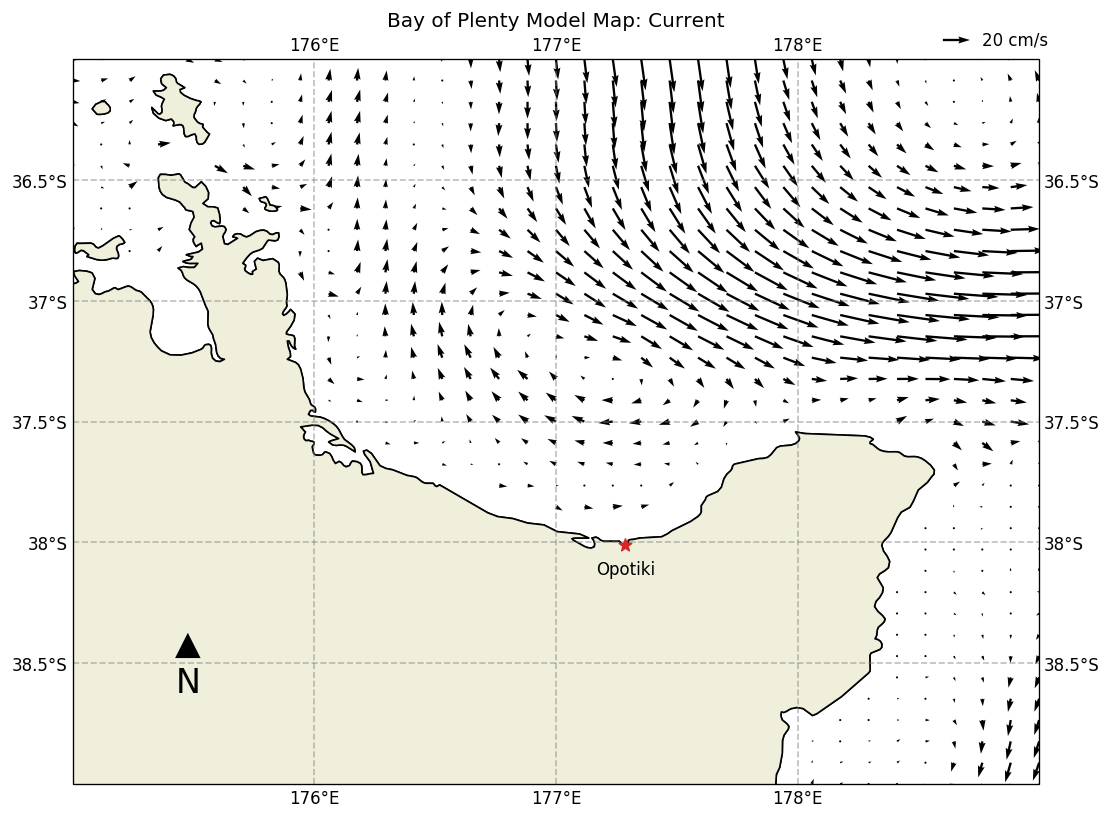

In [227]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [175, 179, -39, -36]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

ms = 12
marker = 'o'

Q = ax.quiver(lonnew+lon_offset,latnew,u2*100,v2*100)
qk = ax.quiverkey(Q, 0.8, 0.9, 20, r'20 cm/s', labelpos='E',zorder=106,coordinates='figure')

# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Bay of Plenty Model Map: Current')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(opotiki_lon+lon_offset,opotiki_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(opotiki_lon, opotiki_lat-0.1, 'Opotiki', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree())
left = 175.5
bottom = -38.5
ax.quiver(left+lon_offset,bottom, 0, 1)


# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)
 
plt.show()

/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/Cartopy-0.17.1.dev174_-py3.6-linux-x86_64.egg/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


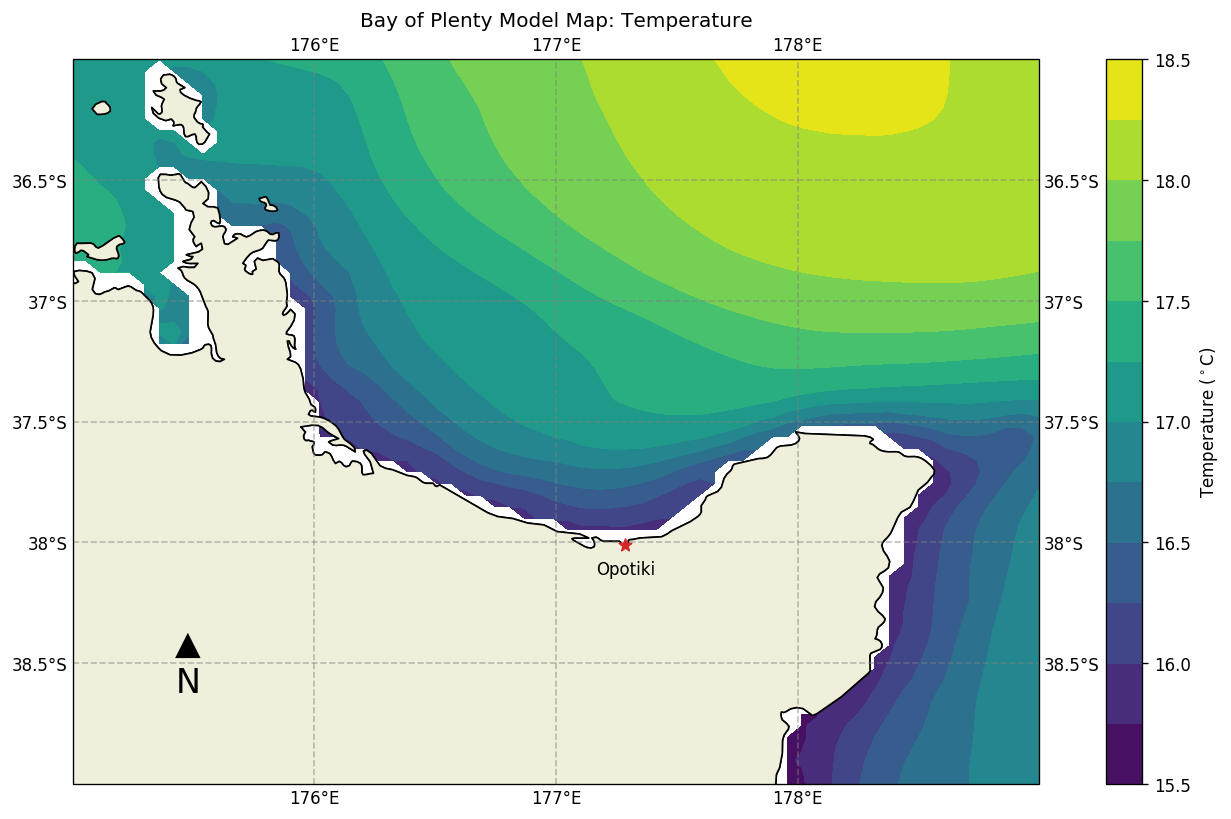

In [233]:
lev = 49

temp = model['temp'][0,lev,:,:]
lon_t = model['lon_rho'][0,:]
lat_t = model['lat_rho'][:,0]

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [175, 179, -39, -36]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

ms = 12
marker = 'o'
levels = np.linspace(15.5,18.5,13)
sm = ax.contourf(lon_t+lon_offset,lat_t,temp,levels=levels)
cb = plt.colorbar(sm, ax=ax, orientation="vertical",fraction=0.046, pad=0.06)
cb.set_label("Temperature ($^\circ$C)")

# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Bay of Plenty Model Map: Temperature')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(opotiki_lon+lon_offset,opotiki_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(opotiki_lon, opotiki_lat-0.1, 'Opotiki', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

left = 175.5
bottom = -38.5
ax.quiver(left+lon_offset,bottom, 0, 1)

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)
 
plt.show()

/home/jjakoboski/.virtualenvs/julie_env/lib/python3.6/site-packages/Cartopy-0.17.1.dev174_-py3.6-linux-x86_64.egg/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


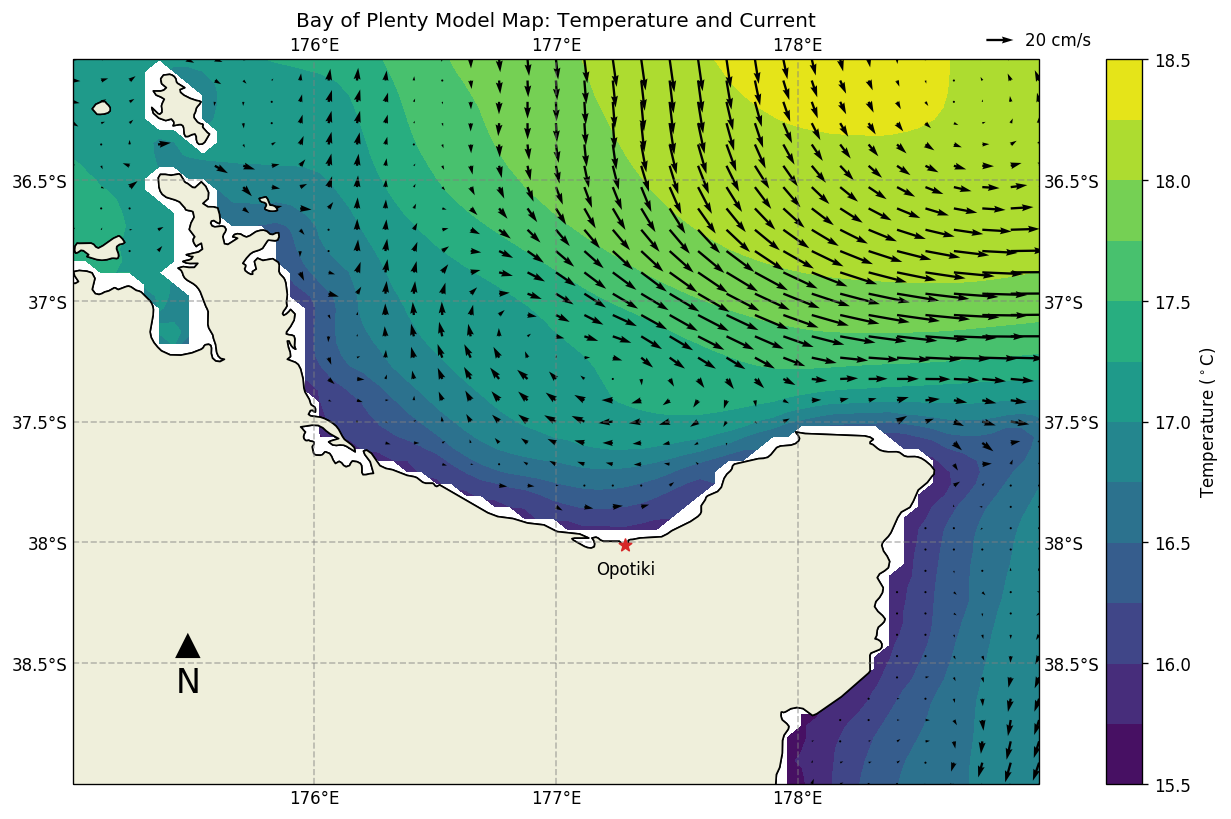

In [234]:

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Create map
box = [175, 179, -39, -36]
#lon_offset = math.floor((box[1]-box[0])/2)
lon_offset = 180

plt.figure(num=None, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon_offset))

ms = 12
marker = 'o'
levels = np.linspace(15.5,18.5,13)
sm = ax.contourf(lon_t+lon_offset,lat_t,temp,levels=levels)
cb = plt.colorbar(sm, ax=ax, orientation="vertical",fraction=0.046, pad=0.06)
cb.set_label("Temperature ($^\circ$C)")

Q=ax.quiver(lonnew+lon_offset,latnew,u2*100,v2*100)
qk = ax.quiverkey(Q, 0.8, 0.9, 20, r'20 cm/s', labelpos='E',zorder=106,coordinates='figure')

# plot various versions of legend
#ax.legend([dot_mpi,dot_aus,dot_ni,dot_si], ["MPI","Australia","North Island","South Island"],loc='lower right')

# plot properties
ax.set_extent(box, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)

plt.title('Bay of Plenty Model Map: Temperature and Current')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

opo = ax.scatter(opotiki_lon+lon_offset,opotiki_lat,s=60,c='tab:red',marker='*',zorder=100)
ax.text(opotiki_lon, opotiki_lat-0.1, 'Opotiki', color='black', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

left = 175.5
bottom = -38.5
ax.quiver(left+lon_offset,bottom, 0, 1)

# need a font that support enough Unicode to draw up arrow. need space after Unicode to allow wide char to be drawm?
ax.text(left,bottom,u'\u25B2 \nN ', color='black', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),zorder=102)
 
plt.show()